In [142]:
using Dates; now()

2019-04-01T14:41:05.852

In [2]:
# load packages
using Revise, MathematicalSystems, LazySets, Reachability, LinearAlgebra, HybridSystems
using Reachability: solve
using Plots
using TaylorIntegration

## Bouncing ball model

In [111]:
@taylorize function bball!(t, x, dx)
    dx[1] = x[2]
    dx[2] = -1.0 + 0.0001*x[1]
    return dx
end

function bouncing_ball(;use_CBBCS=false)
    automaton = LightAutomaton(1)
    
    inv = HalfSpace([-1.0, 0.0], 0.0) # x >= 0
    if !use_CBBCS
        A = [0.0 1.0; 0.0 0.0]
        B = reshape([0.0, -1.0], (2, 1))
        U = Singleton([1.0])
        m1 = ConstrainedLinearControlContinuousSystem(A, B, inv, ConstantInput(U))
    else
        m1 = ConstrainedBlackBoxContinuousSystem(bball!, 2, inv)
    end
    modes = [m1]

    # transition from m1 to m1 (self-loop)
    add_transition!(automaton, 1, 1, 1)
    A = [1.0 0.0; 0.0 -0.75]
    guard = HPolyhedron([HalfSpace([0.0, 1.0], 0.0),   # v ≤ 0
                         HalfSpace([-1.0, 0.0], 0.0),  # x ≥ 0
                         HalfSpace([1.0, 0.0], 0.0)])  # x ≤ 0
    t1 = ConstrainedLinearMap(A, guard)

    # transition annotations
    resetmaps = [t1]

    # switching
    switchings = [AutonomousSwitching()]

    ℋ = HybridSystem(automaton, modes, resetmaps, switchings)

    # initial condition in mode 1
    X0 = Hyperrectangle(low=[10.0, 0.0], high=[10.2, 0.0])
    initial_condition = [(1, X0)]

    system = InitialValueProblem(ℋ, initial_condition)

    options = Options(:mode=>"reach", :T=>6.0, :plot_vars=>[1, 2], :project_reachset=>false)

    return (system, options)
end

bouncing_ball (generic function with 1 method)

**Trying BFFPSV18**

  0.745795 seconds (8.86 M allocations: 486.696 MiB, 23.46% gc time)


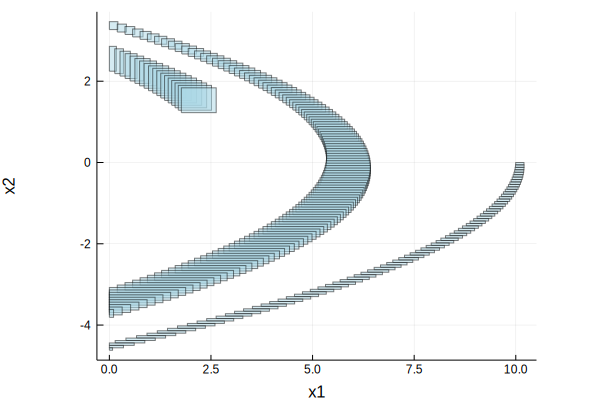

In [123]:
problem, options = bouncing_ball();

options = Options(:mode=>"reach", :T=>12.0, :plot_vars=>[1, 2])

@time sol_BFFPSV18 = solve(problem, options, BFFPSV18(:δ=>0.06), LazyDiscretePost());

plot(sol_BFFPSV18, use_subindices=false, aspectratio=1, alpha=.5, color=:lightblue)

**Trying GLGM06**

[warn] Several option aliases were used for aliases Symbol[:check_invariant_intersection].
  0.729764 seconds (4.63 M allocations: 375.136 MiB, 20.34% gc time)


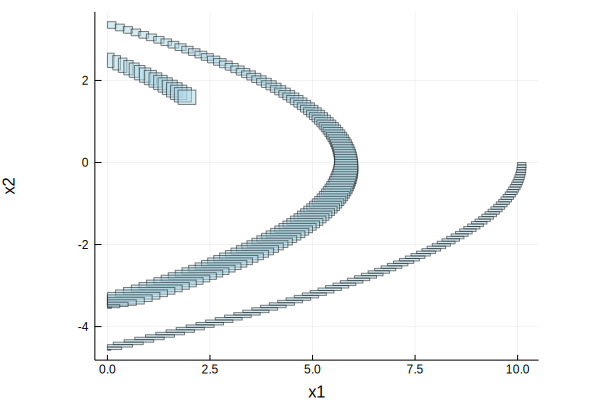

In [124]:
problem, options = bouncing_ball();

options = Options(:mode=>"reach", :T=>12.0, :plot_vars=>[1, 2])

@time sol_GLGM06 = solve(problem, options, GLGM06(:δ=>0.06), LazyDiscretePost(:check_invariant_intersection=>true));

plot(sol_GLGM06, use_subindices=false, aspectratio=1, alpha=.5, color=:lightblue)

**Trying the nonlinear continuous post `TMJets`**

In [140]:
problem, options = bouncing_ball(use_CBBCS=true);

options = Options(:mode=>"reach", :T=>12.0, :plot_vars=>[1, 2], :mode=>"reach")

@time sol_TMJets = solve(problem, options, TMJets(:orderT=>8, :orderQ=>1, :abs_tol=>1e-22, :max_steps=>500),
                         LazyDiscretePost(:check_invariant_intersection=>true));

[warn] Several option aliases were used for aliases Symbol[:check_invariant_intersection].
  0.922884 seconds (9.28 M allocations: 565.262 MiB, 29.30% gc time)


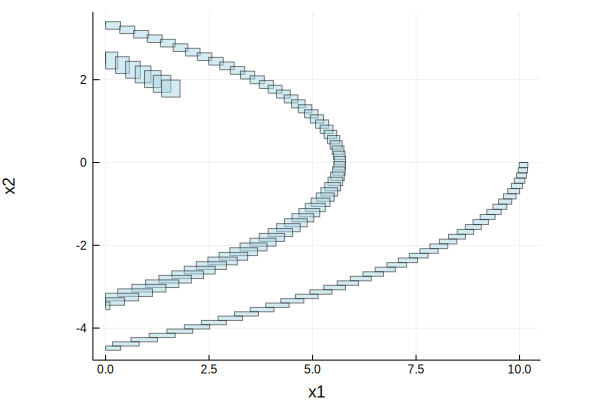

In [141]:
plot(sol_TMJets, use_subindices=false, aspectratio=1, alpha=.5, color=:lightblue)